<a href="https://colab.research.google.com/github/richardOlson/nlp__tranformers/blob/main/Sentiment_analysis_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The steps for doing the NLP are:
1. Data Preprocessing
2. Make an Input Pipeline
3. Building and Training.
4. Making the predicctions.

In [2]:
import tensorflow as tf
# will be using the kaggle api to get the data
!pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"olsonr","key":"2546f671f062f2c8354bd76e441f986a"}'}

In [5]:
# copying the kaggle json into the folder that was made 
# for it.
! cp kaggle.json ~/.kaggle/

In [6]:
# changing the permissions
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [8]:
api = KaggleApi()

In [9]:
api.authenticate()

In [10]:
api.competition_download_file("sentiment-analysis-on-movie-reviews",
                             "test.tsv.zip",
                             path="./")
#api.competition_download_files("sentiment-analysis-on-movie-reviews",
#                              path="./")
api.competition_download_file("sentiment-analysis-on-movie-reviews",
                              "train.tsv.zip", path="./")

100%|██████████| 494k/494k [00:00<00:00, 69.4MB/s]


100%|██████████| 1.28M/1.28M [00:00<00:00, 127MB/s]

In [11]:
import zipfile

In [12]:
with zipfile.ZipFile("./test.tsv.zip", "r",) as zipRef:
  zipRef.extractall("./")
with zipfile.ZipFile("./train.tsv.zip", "r") as zipRef:
  zipRef.extractall("./")


In [13]:
# reading in the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



In [14]:
train = pd.read_csv("./train.tsv", sep="\t", )
print(train.shape)
train.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


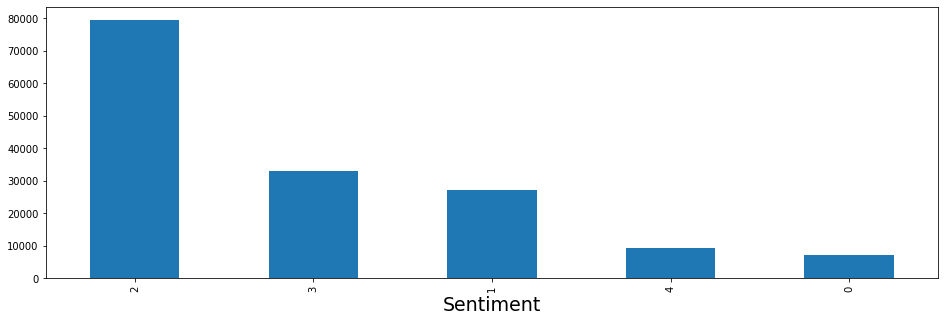

In [15]:
plt.xlabel("Sentiment", size=19)
train['Sentiment'].value_counts().plot(kind="bar", figsize=(16,5), )

In [16]:
# making the size of the tensors --- input id's and the attention mask
seq_num = len(train)
seq_len = 512
seq_num, seq_len

(156060, 512)

In [17]:
# doing the intalling of the transformers library from huggingface
! pip install transformers -q

     |████████████████████████████████| 2.5MB 9.5MB/s 
     |████████████████████████████████| 901kB 46.1MB/s 
     |████████████████████████████████| 3.3MB 21.9MB/s 


In [18]:
from transformers import BertTokenizer

In [19]:
# making the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [20]:
tokens = tokenizer(train['Phrase'].tolist(), max_length=seq_len,
                   truncation=True, padding="max_length",
                   add_special_tokens=True,
                   return_tensors="np")

In [21]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [22]:
# saving as a numpy array to use at a later time
with open("./train_input_id.np", "wb") as fileObj:
  np.save(file=fileObj, arr=tokens["input_ids"] )
with open("./train_atten_mask.np", "wb") as fileObj:
  np.save(file=fileObj, arr=tokens['attention_mask'])

In [23]:
# converting the labels as a numpy array and 
# then will save them
arr = train['Sentiment'].values
arr.shape

(156060,)

In [24]:
labels = np.zeros(shape=(seq_num, arr.max()+1))
labels.shape

(156060, 5)

In [25]:
# putting the values in the labels array
labels[np.arange(seq_num), arr] = 1
labels[:2]

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [26]:
with open("./train_labels.np", "wb") as fileObj:
  np.save(file=fileObj, arr=labels)

In [27]:
# loading the files and then making a dataset
with open("./train_labels.np", "rb") as fileObj:
  train__labels = np.load(fileObj, allow_pickle=True)

with open("./train_atten_mask.np", "rb") as fileObj:
  train_atten_mask = np.load(fileObj, allow_pickle=True)

with open("./train_input_id.np", "rb") as fileObj:
  train_input_id = np.load(fileObj, allow_pickle=True)


In [28]:
dataSet = tf.data.Dataset.from_tensor_slices((train_input_id, train_atten_mask, train__labels))
dataSet.take(1)

<TakeDataset shapes: ((512,), (512,), (5,)), types: (tf.int64, tf.int64, tf.float64)>

In [29]:
def map_function(input_id, mask, labels):
  """
  This is the function that will map the three tensors
  into the format ({input_id, mask}, labels)
  """
  return ({"input_id":input_id, "attention_mask":mask}, labels)

In [30]:
dataSet = dataSet.map(map_function)
dataSet.take(1)

<TakeDataset shapes: ({input_id: (512,), attention_mask: (512,)}, (5,)), types: ({input_id: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [31]:
# now we will shuffle the data and then batch it
batch_size = 16


In [32]:
dataSet = dataSet.shuffle(10000).batch(batch_size=batch_size, drop_remainder=True)

In [33]:
# now we will do the splitting of the data
# into a train and a validation with the 
# train being 90 % while the validation being 10 %
# We will try to find out the number of batches that will be taken to 
# be the 90 percent of the data 
num_train_batches = int((train_input_id.shape[0] / batch_size) * .90)
num_train_batches

8778

In [34]:
train_ds = dataSet.take(num_train_batches)
val_ds = dataSet.skip(num_train_batches)

In [35]:
# saving of the dataset
tf.data.experimental.save(train_ds, "train")
tf.data.experimental.save(val_ds, "val")

In [36]:
# The element spec needs to be saved inorder to be able to load
# the datasets again
train_ds.element_spec == val_ds.element_spec

True

In [37]:
spec = val_ds.element_spec

In [38]:
# going to load the saved dataSet from the files
train_ds = tf.data.experimental.load("train", element_spec=spec)
val_ds = tf.data.experimental.load("val", element_spec=spec)

In [39]:
# now we are going to initialize the bert Model
from transformers import  TFAutoModel

In [40]:
model = TFAutoModel.from_pretrained("bert-base-cased")

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [41]:
model.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [42]:
# now we will be define the input layers 
# making the function that will build the model
def make_model(bertModel):
  # creating the input layers
  atten_mask = tf.keras.layers.Input(shape=(seq_len, ), name="attention_mask",
                                     dtype="int32")
  input_id = tf.keras.layers.Input(shape=(seq_len, ), name="input_id",
                                    dtype="int32")
  
  # now getting the model of bert and then will get the info from it
  # using the index 1 to get a pooled output so that the output is a
  # 2d output
  bert_output = bertModel.bert(input_ids=input_id, attention_mask=atten_mask)[1]

  # now adding the dense layer at the end
  x = tf.keras.layers.Dense(1024, activation="relu")(bert_output)
  y = tf.keras.layers.Dense(5, activation="softmax")(x)
  # creating the model from Tensorflow
  model = tf.keras.Model(inputs=[input_id, atten_mask], outputs=y)

  return model




In [43]:
# using the function above to get the model and then wll do the compiling of the mode
model = make_model(bertModel=model)
model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_id (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_id[0][0]                   
                                                                 attention_mask[0][0]             
_______________________________________________________

In [44]:
# will now make the bert layer so that it is not trainable
model.layers[2].trainable = False

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_id (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_id[0][0]                   
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[0][1]                   

In [46]:
myOptimizer = tf.optimizers.Adam(learning_rate=1e-5)
myLoss = tf.keras.losses.CategoricalCrossentropy()
myAcc = tf.keras.metrics.CategoricalAccuracy()

In [47]:
model.compile(optimizer=myOptimizer, loss=myLoss, metrics=[myAcc])

In [48]:
# will practice to pull the dataSets from the memory and will then use them
train_ds = tf.data.experimental.load("train", element_spec=spec)
val_dx = tf.data.experimental.load("val", element_spec=spec)
train_ds.take(1)

<TakeDataset shapes: ({input_id: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_id: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [ ]:
# now will do the training of the data
history = model.fit(x=train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
8778/8778 [==============================] - 6843s 779ms/step - loss: 1.1591 - categorical_accuracy: 0.5362 - val_loss: 1.1376 - val_categorical_accuracy: 0.5438
Epoch 2/3
1639/8778 [====>.........................] - ETA: 1:24:48 - loss: 1.0565 - categorical_accuracy: 0.5856

In [ ]:
# saving the model for later use
model.save("sentiment_model")

In [ ]:
# downloading the file of model
files.download("sentiment_model")

In [ ]:
# doing some predictions with the model after having been saved
def prep_data(text: str):
  """
  This is the function that will prepare the 
  data to be used in the predict funtion
  """
  tokens = tokenizer(text, max_length=512, trucation=True, 
            padding="max_length",
            add_special_tokens=True, 
            return_tensors="tf")
  
  return {"input_ids": tf.cast(tokens["input_ids"], tf.float64),
          "attention_mask": tf.cast(tokens["attention_mask"], tf.float64)}

In [ ]:
probs = model.predict(prep_data("Hey, I love you!"))[0]

In [ ]:
np.argmax(probs)

In [ ]:
probs = model.predict(prep_data("I hate eating lettuce"))[0]
np.argmax(probs)